In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import unary, binary, monoid, semiring

## Create and visualize a Matrix

In [2]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]

In [3]:
rows, cols, weights = data
m = Matrix.from_coo(rows, cols, weights)
m
# Size of the sparse matrix is 7x7 with 12 non-zero elements of type INT64

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix     12      7      7  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5  6
0     2     3         
1              8     4
2                 1   
3  3     3            
4                 7   
5        1            
6        5  7  3

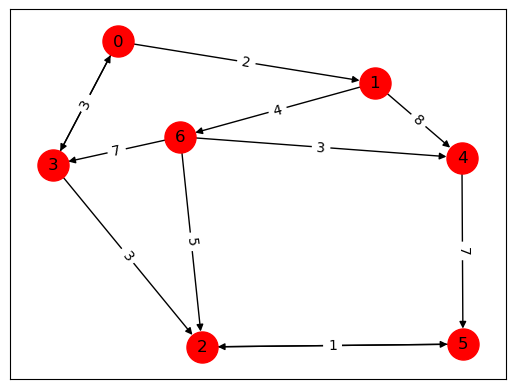

In [5]:
gb.viz.draw(m)

## Single-source Shortest Path

This uses the **_min-plus_** semiring because we want to add the edges, then take the minimum length of available paths.

In [8]:
# Create a vector and initialize a starting vertex (1) with a distance of zero
v = Vector(m.dtype, m.nrows)
v[1] << 0
v

"v_1"      nvals  size  dtype        format
gb.Vector      1     7  INT64  bitmap (iso)
-------------------------------------------
index 0  1 2 3 4 5 6
value    0

In [9]:
m

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix     12      7      7  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5  6
0     2     3         
1              8     4
2                 1   
3  3     3            
4                 7   
5        1            
6        5  7  3

In [10]:
# v @ m will give us one step in a Breadth-first search
w = v.dup()
w << v.vxm(m, semiring.min_plus)
w

"v_2"      nvals  size  dtype  format
gb.Vector      2     7  INT64  bitmap
-------------------------------------
index 0 1 2 3  4 5  6
value          8    4

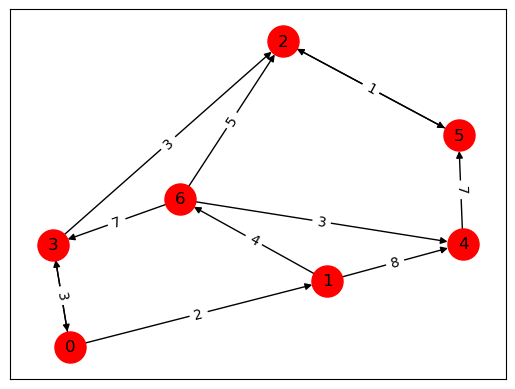

In [11]:
# Look again at m and see that vertex 1 points to vertices 4 and 6 with the weights indicated
gb.viz.draw(m)

We have the right semiring, but we already lost the initial distance=0 for vertex 1. How do we keep that information around as we step thru the BFS?

GraphBLAS has a builtin accumulator available for every operation.
Because it's C-based, you pass in the output object and it accumulates its existing values with the result, then returns itself.

In [12]:
w = v.dup()
w(binary.min) << v.vxm(m, semiring.min_plus)
w
# Now we see that the zero distance for vertex 1 is preserved

"v_3"      nvals  size  dtype  format
gb.Vector      3     7  INT64  bitmap
-------------------------------------
index 0  1 2 3  4 5  6
value    0      8    4

Let's take another step

In [13]:
w(binary.min) << w.vxm(m, semiring.min_plus)
w
# We see that the path to vertex 4 is now shorter. That's `min` doing its thing.
# Verify the other path distances from vertex 1 with at most two hops

"v_3"      nvals  size  dtype  format
gb.Vector      6     7  INT64  bitmap
-------------------------------------
index 0  1  2   3  4   5  6
value    0  9  11  7  15  4

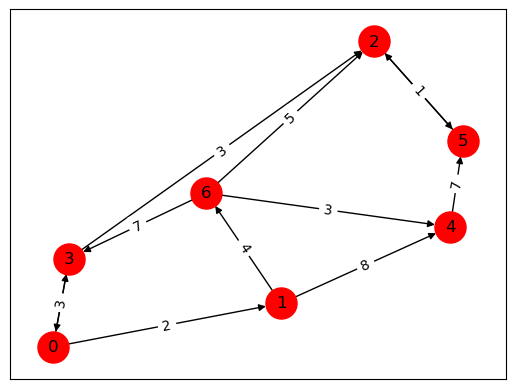

In [14]:
gb.viz.draw(m)

The algorithm repeats until a new computation is the same as the previous result

In [15]:
w = v.dup()
while True:
    w_old = w.dup()
    w(binary.min) << w.vxm(m, semiring.min_plus)
    if w.isequal(w_old):
        break
w

"v_4"      nvals  size  dtype  format
gb.Vector      7     7  INT64    full
-------------------------------------
index   0  1  2   3  4   5  6
value  14  0  9  11  7  10  4

## Alternate solution without using an accumulator

In the min_plus semiring, the "empty" value of a sparse matrix is not actually 0, but +infinity.

That way, `min(anything, +inf) = anything`, similar to the normal addition 0 of `add(anything, 0) = anything`.

A clever trick sets the diagonal of the matrix to all zeros. This makes it behave like the Identity matrix for the min_plus semiring.

Observe:

In [16]:
m_ident = Matrix.from_coo(range(7), range(7), [0] * 7)
m_ident

"M_1"      nvals  nrows  ncols  dtype         format
gb.Matrix      7      7      7  INT64  bitmapr (iso)
----------------------------------------------------
   0  1  2  3  4  5  6
0  0                  
1     0               
2        0            
3           0         
4              0      
5                 0   
6                    0

In [17]:
v.clear()
v.build([1], [0])
v

"v_1"      nvals  size  dtype        format
gb.Vector      1     7  INT64  bitmap (iso)
-------------------------------------------
index 0  1 2 3 4 5 6
value    0

In [18]:
v << v.vxm(m_ident, semiring.min_plus)
v
# See how it preserved v exactly

"v_1"      nvals  size  dtype        format
gb.Vector      1     7  INT64  bitmap (iso)
-------------------------------------------
index 0  1 2 3 4 5 6
value    0

In [19]:
# Let's try again
v.clear()
v.build([0, 1, 4], [14, 0, 77])
v << v.vxm(m_ident, semiring.min_plus)
v

"v_1"      nvals  size  dtype  format
gb.Vector      3     7  INT64  bitmap
-------------------------------------
index   0  1 2 3   4 5 6
value  14  0      77

So zeros along the diagonal preserve what you already have in `v` without adding any new path information. That's the behavior we want, so let's update `m` with zeros on the diagonal and repeat SSSP without using accumulators.

In [20]:
for i in range(m.nrows):
    m[i, i] << 0
m

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix     19      7      7  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5  6
0  0  2     3         
1     0        8     4
2        0        1   
3  3     3  0         
4              0  7   
5        1        0   
6        5  7  3     0

In [21]:
# Reset v
v.clear()
v[1] << 0
v

"v_1"      nvals  size  dtype        format
gb.Vector      1     7  INT64  bitmap (iso)
-------------------------------------------
index 0  1 2 3 4 5 6
value    0

In [22]:
# Take one step (notice no accumulator is specified)
v << v.vxm(m, semiring.min_plus)
v

"v_1"      nvals  size  dtype  format
gb.Vector      3     7  INT64  bitmap
-------------------------------------
index 0  1 2 3  4 5  6
value    0      8    4

In [23]:
# Repeat until we're converged
while True:
    w = v.dup()
    v << v.vxm(m, semiring.min_plus)
    if v.isequal(w):
        break
v

"v_1"      nvals  size  dtype  format
gb.Vector      7     7  INT64    full
-------------------------------------
index   0  1  2   3  4   5  6
value  14  0  9  11  7  10  4

### And that's SSSP in 5 very readable lines of Python, thanks to GraphBLAS